In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

In [2]:
# Define global constants
kB = 1.380649 * 10**-23    # Boltzmann
h = 6.62607 * 10**-34      # Planck
R = 1.9858775 * 10**-3     # universal gas (kcal / mol / K)

#### Solve for $\Delta G_{eff}^{\ddagger}$ in terms of $\Delta G_{m,j}^{\ddagger}$

$\Delta G_{eff}^{\ddagger}$ is what they solve for experimentally, by treating all barriers equal.

\begin{align}
    P_{m} &=  P_{eff} \\
    A \frac{ \exp{ \frac{\Delta G_{ms} - \Delta G_{sm}}{R T} } }{ \sum_{j=1}^{M} \left( \frac{1}{\lambda_{M,j}} \right)  \exp{\left( \frac{\Delta G_{m,j}}{R T} \right)} } &= B \exp{ \left( \frac{-\Delta G_{eff}}{R T} \right) } \\
\end{align}

Membrane thickness: 399.9 nm


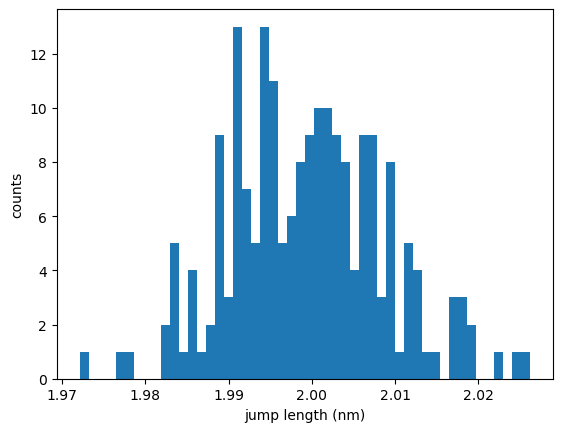

In [3]:
# Input jump info
n_jumps = 200 # number of jumbers in the direction of transport
lam_avg = 2 # average jump length (nm)
lam_sig = 0.01 # std of jump lengths
rng = np.random.default_rng()
lam = rng.normal(loc=lam_avg, scale=lam_sig, size=n_jumps)
plt.hist(lam, bins=50)
plt.ylabel('counts')
plt.xlabel('jump length (nm)')

delta = lam.sum()
print('Membrane thickness: {:.1f} nm'.format(delta))

# Input interface barriers
dG_sm = 10
dG_ms = 8
lam_sm = 2
lam_ms = 2

# Input temperature
T = 300 # K

# Input number of iterations to calculate dG_eff
n_iter = 50000

In [4]:
def calculate_dG_eff(dG_j, lam, T=300, dG_sm=10, dG_ms=10, lam_sm=2, lam_ms=2, delta=300, R=1.9858775 * 10**-3, kB=1.380649 * 10**-23, h=6.62607 * 10**-34):
    num = lam_sm / lam_ms * np.exp((dG_ms - dG_sm) / R / T)
    den = lam.mean()**2 / delta * np.sum( np.exp(dG_j / R / T) / lam )
    return -R * T * np.log(num / den)


def calculate_P(dG_j, T=300, dG_sm=10, dG_ms=10, lam_sm=2, lam_ms=2, lam=2, delta=500, R=1.9858775 * 10**-3, kB=1.380649 * 10**-23, h=6.62607 * 10**-34):
    num = (lam_sm / lam_ms / delta) * (kB*T / h)**3 * np.exp(-(dG_sm - dG_ms) / R / T)
    den = np.sum( np.exp(dG_j / R / T) )
    return num / den
    
    
def plot_kde(data, x, xlabel=None, ylabel=None, title=None, label=None, ax=None):
    
    kde = gaussian_kde(data)
    y = kde.evaluate(x)
    if ax is not None:
        ax.plot(x, y, label=label)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        if title is not None:
            ax.set_title(title)
    else:
        plt.plot(x, y, label=label)
        if xlabel is not None:
            plt.xlabel(xlabel)
        if ylabel is not None:
            plt.ylabel(ylabel)
        if title is not None:
            plt.title(title)
            
    return y

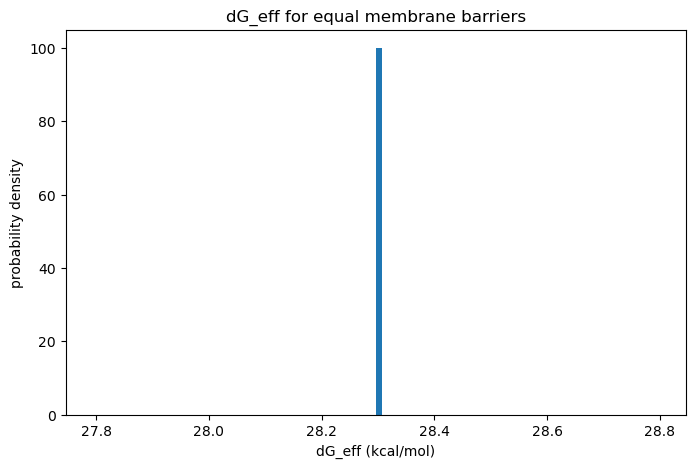

In [5]:
# Input parameters for the dG distribution (all equal)
mu = 30
sigma = 5
rng = np.random.default_rng()
dG_m = rng.normal(loc=mu, scale=sigma, size=1)

dG_eff = []
P = []
for _ in range(n_iter):
    # Sample a single free energy barrier for the membrane
    dG_j = np.ones(n_jumps)*dG_m
    
    # Calculate dG_eff and save for plotting
    dG = calculate_dG_eff(dG_j, lam, T=T, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, delta=delta)
    dG_eff.append(dG)
    
    
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.hist(dG_eff, bins=100, density=True)
ax.set_xlabel('dG_eff (kcal/mol)')
ax.set_ylabel('probability density')
ax.set_title('dG_eff for equal membrane barriers');

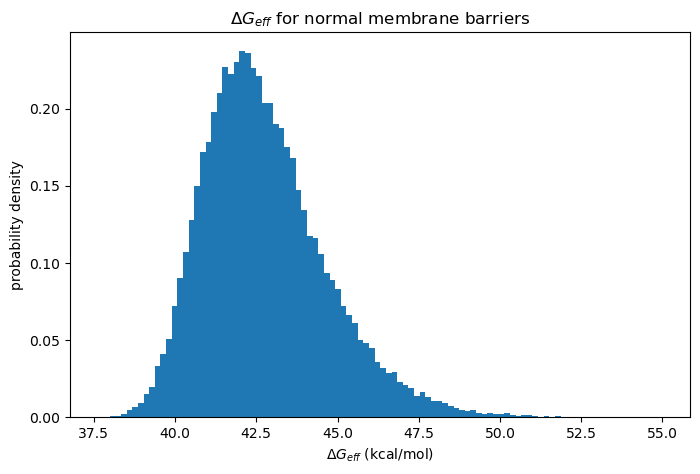

In [6]:
# Input parameters for the dG distribution (normal)
mu = 30
sigma = 5

rng = np.random.default_rng()

dG_eff = []
for _ in range(n_iter):
    # Sample a distribution of free energy barriers for the membrane
    dG_j = rng.normal(loc=mu, scale=sigma, size=n_jumps)
    
    # Calculate dG_eff and save for plotting
    dG = calculate_dG_eff(dG_j, lam, T=T, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, delta=delta)
    dG_eff.append(dG)

    
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.hist(dG_eff, bins=100, density=True, label='histogram')
ax.set_xlabel('$\Delta G_{eff}$ (kcal/mol)')
ax.set_ylabel('probability density')
ax.set_title('$\Delta G_{eff}$ for normal membrane barriers')

# x = np.linspace(min(dG_eff), max(dG_eff), num=50)
# kde = plot_kde(dG_eff, x, ax=ax, label='kde')
# ax.legend();

plt.savefig('dG_eff_normal_30_5_dist.png')

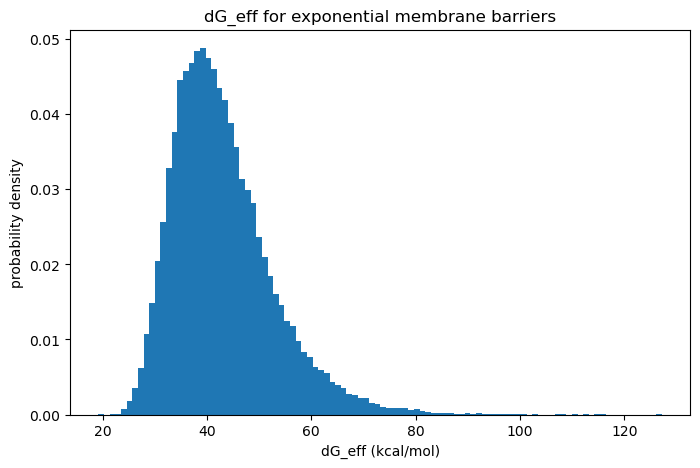

In [7]:
# Input parameters for the dG distribution (exponential)
beta = 7.5

dG_eff = []
for _ in range(n_iter):
    # Sample a distribution of free energy barriers for the membrane
    rng = np.random.default_rng()
    dG_j = rng.exponential(scale=beta, size=n_jumps)
    
    # Calculate dG_eff and save for plotting
    dG = calculate_dG_eff(dG_j, lam, T=T, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, delta=delta)
    dG_eff.append(dG)

    
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.hist(dG_eff, bins=100, density=True, label='histogram')
ax.set_xlabel('dG_eff (kcal/mol)')
ax.set_ylabel('probability density')
ax.set_title('dG_eff for exponential membrane barriers');

# x = np.linspace(min(dG_eff), max(dG_eff), num=50)
# kde = plot_kde(dG_eff, x, ax=ax, label='kde')
# ax.legend();

#### Calculate permeabilities from distribution of membrane barriers

In [8]:
# # Input parameters for the dG distribution (normal)
# mu = 30
# sigma = 5

# P = []
# for _ in range(n_iter):
#     # Sample a distribution of free energy barriers for the membrane
#     # rng = np.random.default_rng()
#     dG_j = rng.normal(loc=mu, scale=sigma, size=n_jumps)
    
#     # Calculate P
#     perm = calculate_P(dG_j, T=T, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, lam=lam, delta=delta)
#     P.append(perm)
    
    
# fig, ax = plt.subplots(1,1, figsize=(8,5))
# ax.hist(P, bins=100, density=True, label='histogram')
# ax.set_xlabel('Permeability (?)')
# ax.set_ylabel('probability density')
# ax.set_title('Permeability for normal membrane barriers')

# x = np.linspace(min(P), max(P), num=50)
# kde = plot_kde(P, x, ax=ax, label='kde')
# ax.legend();

In [9]:
# Input parameters for the dG distribution (normal)
mu = 30
sigma = 5

rng = np.random.default_rng()

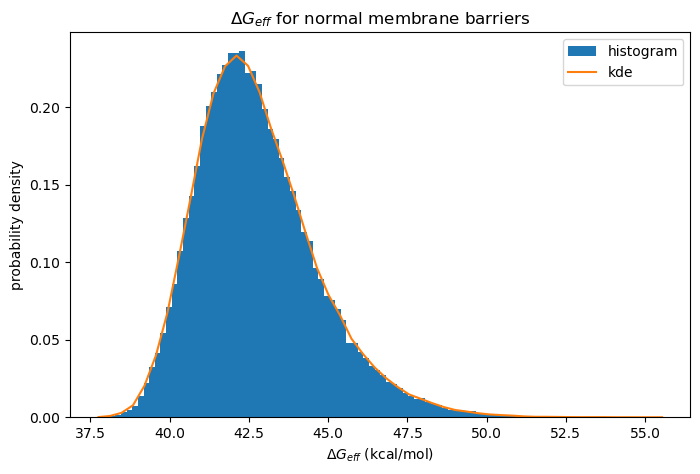

In [10]:
dG_eff = []
for _ in range(n_iter):
    # Sample a distribution of free energy barriers for the membrane
    dG_j = rng.normal(loc=mu, scale=sigma, size=n_jumps)
    
    # Calculate dG_eff and save for plotting
    dG = calculate_dG_eff(dG_j, lam, T=T, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, delta=delta)
    dG_eff.append(dG)

    
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.hist(dG_eff, bins=100, density=True, label='histogram')
ax.set_xlabel('$\Delta G_{eff}$ (kcal/mol)')
ax.set_ylabel('probability density')
ax.set_title('$\Delta G_{eff}$ for normal membrane barriers')

x = np.linspace(min(dG_eff), max(dG_eff), num=50)
kde = plot_kde(dG_eff, x, ax=ax, label='kde')
ax.legend();

plt.savefig('dG_eff_normal_{}_{}_dist.png'.format(mu, sigma))

Maximum membrane barrier: 47.6689
Minimum membrane barrier: 16.3671
Mean membrane barrier: 30.3419
Solution-membrane interface: 10.0000
Membrane-solution interface: 8.0000
Max - effective = 1.1520


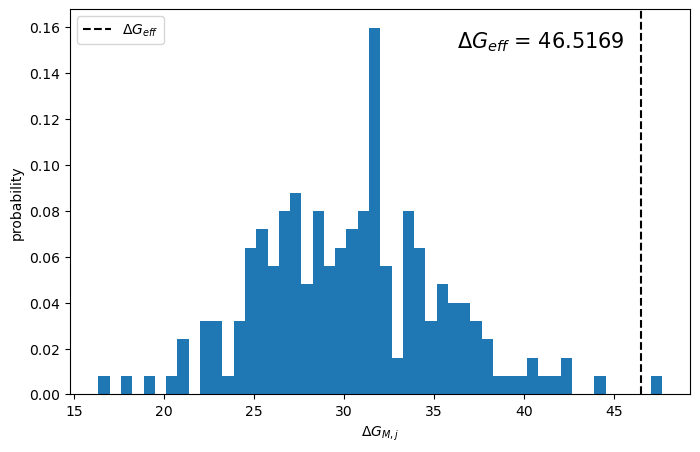

In [11]:
# Sample a distribution of free energy barriers for the membrane
dG_j = rng.normal(loc=mu, scale=sigma, size=n_jumps)
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.hist(dG_j, bins=50, density=True)
plt.xlabel('$\Delta G_{M,j}$')
plt.ylabel('probability')

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

# Calculate dG_eff and save for plotting
dG = calculate_dG_eff(dG_j, lam, T=T, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, delta=delta)
plt.text(dG*0.98, ymax - ymax*0.1, '$\Delta G_{eff}$ = %.4f' % (dG), fontsize=15, ha='right')
plt.axvline(dG, c='k', ls='dashed', label='$\Delta G_{eff}$')
plt.legend()

plt.savefig('membrane_dist_normal_{}_{}.png'.format(mu, sigma))

print('Maximum membrane barrier: {:.4f}'.format(max(dG_j)))
print('Minimum membrane barrier: {:.4f}'.format(min(dG_j)))
print('Mean membrane barrier: {:.4f}'.format(dG_j.mean()))
print('Solution-membrane interface: {:.4f}'.format(dG_sm))
print('Membrane-solution interface: {:.4f}'.format(dG_ms))
print('Max - effective = {:.4f}'.format(max(dG_j) - dG))